A highly fine tuned autoencoder model should be able to reconstruct the same input which was passed in the first layer. In this kernel, I will walk you through the working of autoencoders and their implementation. Autoencoders are widly used with the image data and some of their use cases are:

* Dimentionality Reduction
* Image Compression
* Image Denoising
* Image Generation
* Feature Extraction

Remember the typical Keras workflow looks:

1.  Define your training data: input tensors and target tensors.
2.  Define a network of layers (or model ) that maps your inputs to your targets.
3.  Configure the learning process by choosing a loss function, an optimizer, and some metrics to monitor.
4.  Iterate on your training data by calling the fit() method of your model.


Load the libraries 

In [3]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

Using TensorFlow backend.


### Dataset Prepration

Load the dataset, separate predictors and target, normalize the inputs.

The data used can be found here: 
https://github.com/zalandoresearch/fashion-mnist

In [4]:
from keras.datasets import fashion_mnist

(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()
## normalize and reshape the predictors  
train_x = train_x / 255
val_x = val_x / 255

train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

4423680/4422102 [==============================] - 2s 0us/step


In [3]:
train_x.shape

(60000, 784)

## Image Reconstruction

### Create Autoencoder architecture  (using Functional API)

In this section, lets create an autoencoder architecture. The encoding part comprises of three layers with 2000, 1200, and 500 nodes. Encoding architecture is connected to latent view space comprising of 10 nodes which is then connected to decoding architecture with 500, 1200, and 2000 nodes. The final layer comprises of exact number of nodes as the input layer.

In [4]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(50, activation='sigmoid', name="latent")(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

### Re-create the Autoencoder architecture using the Sequential API


In [0]:
## Re-create the Autoencoder architecture using the Sequential model API 

In [0]:
a = model.layers[4]

In [7]:
a.name 

'latent'

In [8]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              1177500   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
latent (Dense)               (None, 50)                25050     
_________________________________________________________________
dense_4 (Dense)              (None, 500)               25500     
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              5010

In [9]:
np.shape(train_x)

(60000, 784)

Next, we will train the model with early stopping callback.

In [0]:
?EarlyStopping

In [11]:
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, 
                               patience=10, verbose=1, mode='auto')

model.fit(train_x, train_x, epochs=20, batch_size=2048, 
          validation_data=(val_x, val_x), 
          callbacks=[early_stopping])





Train on 60000 samples, validate on 10000 samples
Epoch 1/20





60000/60000 [==============================] - 44s 740us/step - loss: 0.0831 - val_loss: 0.0534
Epoch 2/20
60000/60000 [==============================] - 43s 719us/step - loss: 0.0449 - val_loss: 0.0389
Epoch 3/20
60000/60000 [==============================] - 43s 718us/step - loss: 0.0371 - val_loss: 0.0347
Epoch 4/20
60000/60000 [==============================] - 43s 715us/step - loss: 0.0326 - val_loss: 0.0292
Epoch 5/20
60000/60000 [==============================] - 43s 719us/step - loss: 0.0280 - val_loss: 0.0269
Epoch 6/20
60000/60000 [==============================] - 43s 719us/step - loss: 0.0252 - val_loss: 0.0250
Epoch 7/20
60000/60000 [==============================] - 43s 717us/step - loss: 0.0239 - val_loss: 0.0236
Epoch 8/20
60000/60000 [==============================] - 43s 715us/step - loss: 0.0225 - val_loss: 0.0218
Epoch 9/20
60000/60000 [==============================] - 43s 714us/step - loss: 0.02

In [0]:
preds = model.predict(val_x)

**Predicted : Autoencoder Output**

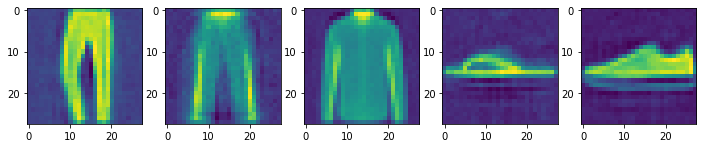

In [13]:
f, ax = plt.subplots(1,5)
f.set_size_inches(12, 6)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()

In [14]:
train_y[range(5,10)]

array([2, 7, 2, 5, 5], dtype=uint8)

**Inputs: Actual Images**

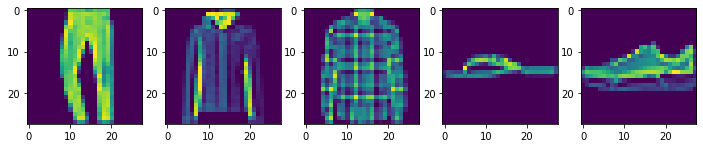

In [15]:
f, ax = plt.subplots(1,5)
f.set_size_inches(12, 6)
for i in range(5,10):
    ax[i-5].imshow(val_x[i].reshape(28, 28))
plt.show()

## Classifier on top of an encoding

In [0]:
# Here you get the layer that interests you from model_a, 
# it is still linked to its input layer, you just need to remember it for later
intermediate_from_a = model.get_layer('latent').output

In [0]:
intermediate_layer_model = Model(inputs=model.input, 
                                 outputs=model.get_layer("latent").output)

In [0]:
latent_val = intermediate_layer_model.predict(val_x)
latent_train = intermediate_layer_model.predict(train_x)

In [0]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
encoded_train_y = encoder.transform(train_y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_train_y = np_utils.to_categorical(encoded_train_y)

In [0]:
encoded_val_y = encoder.transform(val_y)
dummy_val_y = np_utils.to_categorical(encoded_val_y)

In [21]:
np.shape(dummy_val_y)[1]

10

In [22]:
np.shape(latent_train)

(60000, 50)

In [23]:
from keras import optimizers, regularizers
from keras.models import Sequential

model2 = Sequential()
input_size = np.shape(latent_view)[1]
# add L2 weight regularization to logistic regression
regularizer = regularizers.l2(0.01)
model2.add(Dense(units=10, activation='sigmoid', 
                 input_shape=(input_size.value,) , kernel_regularizer=regularizer))

# Init rmsprop
rmsprop_small = optimizers.RMSprop(lr=0.01)
#rmsprop_large = optimizers.RMSprop(lr=0.5)

model2.compile(loss='categorical_crossentropy', optimizer=rmsprop_small, metrics=['accuracy'])
history_small_lr= model2.fit(latent_train, dummy_train_y, 
                             epochs=200, batch_size=1024, 
                             validation_data=(latent_val, dummy_val_y), verbose=1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 0s 7us/step - loss: 1.8019 - acc: 0.6408 - val_loss: 1.6068 - val_acc: 0.7279
Epoch 2/200
60000/60000 [==============================] - 0s 2us/step - loss: 1.5736 - acc: 0.7237 - val_loss: 1.5849 - val_acc: 0.6883
Epoch 3/200
60000/60000 [==============================] - 0s 3us/step - loss: 1.5572 - acc: 0.7281 - val_loss: 1.5621 - val_acc: 0.7267
Epoch 4/200
60000/60000 [==============================] - 0s 3us/step - loss: 1.5466 - acc: 0.7302 - val_loss: 1.5555 - val_acc: 0.7343
Epoch 5/200
60000/60000 [==============================] - 0s 3us/step - loss: 1.5379 - acc: 0.7283 - val_loss: 1.5463 - val_acc: 0.7223
Epoch 6/200
60000/60000 [==============================] - 0s 2us/step - loss: 1.5290 - acc: 0.7308 - val_loss: 1.5405 - val_acc: 0.7222
Epoch 7/200
60000/60000 [========

In [0]:
pred_val = model2.predict(latent_val)

## Noisy images

Lets add sample noise - Salt and Pepper

In [0]:
## recreate the train_x array and val_x array
(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()

## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)


In [0]:
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

Before adding noise

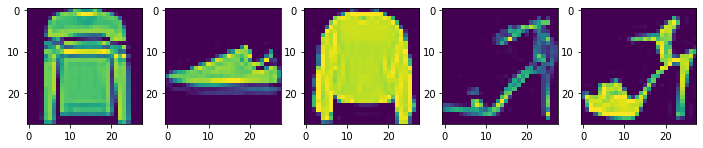

In [7]:
f, ax = plt.subplots(1,5)
f.set_size_inches(12, 6)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

After adding noise

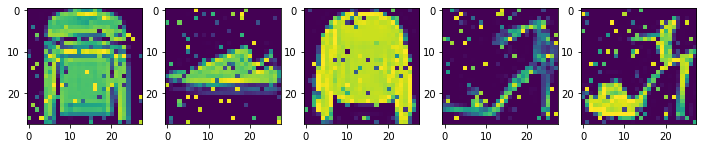

In [8]:
f, ax = plt.subplots(1,5)
f.set_size_inches(12, 6)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

## Convolutional Autoencoders

Lets now create the model architecture for the autoencoder. Lets understand what type of network needs to be created for this problem.

Encoding Architecture:

The encoding architure is composed of 3 Convolutional Layers and 3 Max Pooling Layers stacked one by one. Relu is used as the activation function in the convolution layers and padding is kept as "same". Role of max pooling layer is to downsample the image dimentions. This layer applies a max filter to non-overlapping subregions of the initial representation.

Decoding Architecture:

Similarly in decoding architecture, the convolution layers will be used having same dimentions (in reverse manner) as the encoding architecture. But instead of 3 maxpooling layers, we will be adding 3 upsampling layers. Again the activation function will be same (relu), and padding in convolution layers will be same as well. Role of upsampling layer is to upsample the dimentions of a input vector to a higher resolution / dimention. The max pooling operation is non-invertible, however an approximate inverse can be obtained by recording the locations of the maxima within each pooling region. Umsampling layers make use of this property to project the reconstructions from a low dimentional feature space

In [9]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [10]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0   

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])




Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 17s 287us/step - loss: 0.0986 - val_loss: 0.0530
Epoch 2/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.0445 - val_loss: 0.0376
Epoch 3/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.0334 - val_loss: 0.0293
Epoch 4/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.0273 - val_loss: 0.0254
Epoch 5/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.0244 - val_loss: 0.0235
Epoch 6/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.0228 - val_loss: 0.0221
Epoch 7/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.0215 - val_loss: 0.0209
Epoch 8/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.0208 - val_loss: 0.0202
Epoch 9/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.0199 - val_

Lets obtain predictions

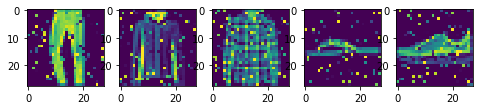

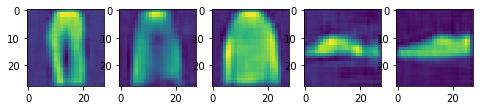

In [14]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(8, 4)
for i in range(5,10):
    ax[i-5].imshow(val_x_n[i].reshape(28, 28))

f, ax = plt.subplots(1,5)
f.set_size_inches(8, 4)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))


plt.show()